In [2]:
import numpy as np
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from renormalization_sg import *

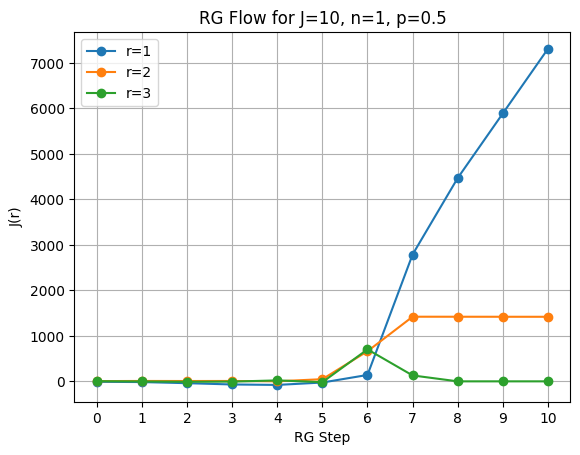

In [7]:
# RG flow

J = 10
n = 1
p = 0.5
max_k = 1000

all_Js = generate_rg_flow(J0=J, n=n, p=p, max_k=max_k, num_steps=10, seed=42)

# Plot J vs RG step for first num_r_to_plot r
fig = plt.figure()
steps = range(len(all_Js))
for r_idx in range(3):
    Js_step = [all_Js[s][r_idx] for s in steps]
    plt.plot(steps, [float(j) for j in Js_step], label=f'r={r_idx+1}', marker='o')
plt.xlabel('RG Step')
plt.ylabel('J(r)')
plt.title(f'RG Flow for J={J}, n={n}, p={p}')
plt.xticks(steps)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Plot J vs RG step for first num_r_to_plot r
fig = plt.figure()
steps = range(len(all_Js))
for r_idx in range(3):
    Js_step = [all_Js[s][r_idx] for s in steps]
    plt.plot(steps, [float(j) for j in Js_step], label=f'r={r_idx+1}', marker='o')
plt.xlabel('RG Step')
plt.ylabel('J(r)')
plt.title(f'RG Flow for J={J}, n={n}, p={p}')
plt.xticks(steps)
plt.legend()
plt.grid(True)
plt.show()

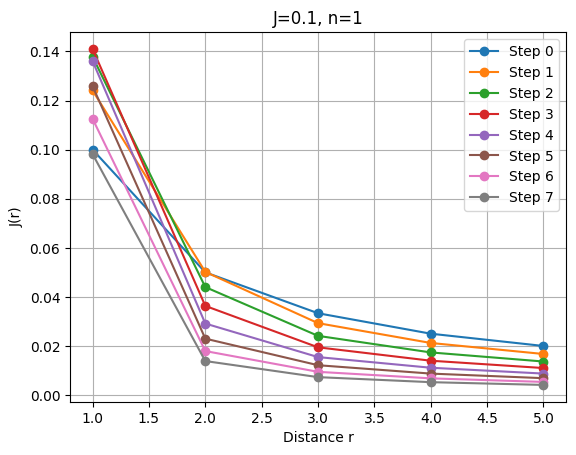

CPU times: user 2min 56s, sys: 1.28 s, total: 2min 57s
Wall time: 3min 1s


In [17]:
%%time
J = .1
n = 1

plot_rg_steps_vs_r(
    J0=J, n=n, p=0,
    max_k=10000, num_steps=7,
    plot_up_to_r=5, seed=19
)

## Critical point

In [6]:
find_J_c(
    n=.5, p=0,
    max_k=2000,
    tol=1e-4,
    J_low=-3, J_high=-0.01,
    seed=19
)

mpf('-2.999908752441406250000006352747104407252543')

In [2]:
n_values = np.linspace(.01, 2, 30, True)
n_values

array([0.01      , 0.07862069, 0.14724138, 0.21586207, 0.28448276,
       0.35310345, 0.42172414, 0.49034483, 0.55896552, 0.62758621,
       0.6962069 , 0.76482759, 0.83344828, 0.90206897, 0.97068966,
       1.03931034, 1.10793103, 1.17655172, 1.24517241, 1.3137931 ,
       1.38241379, 1.45103448, 1.51965517, 1.58827586, 1.65689655,
       1.72551724, 1.79413793, 1.86275862, 1.93137931, 2.        ])

For n=0.01, J_c=-0.000000715355737280845642093486968862938502407
For n=0.07862068965517241, J_c=-2.999999284744262719154357910156250868611
For n=0.14724137931034484, J_c=-2.999999284744262719154357910156250868611
For n=0.21586206896551724, J_c=-2.999999284744262719154357910156250868611
For n=0.28448275862068967, J_c=-2.999999284744262719154357910156250868611
For n=0.3531034482758621, J_c=-2.999999284744262719154357910156250868611
For n=0.42172413793103447, J_c=-2.999999284744262719154357910156250868611
For n=0.4903448275862069, J_c=-2.999999284744262719154357910156250868611
For n=0.5589655172413793, J_c=-2.999999284744262719154357910156250868611
For n=0.6275862068965518, J_c=-2.999999284744262719154357910156250868611
For n=0.6962068965517242, J_c=-2.999999284744262719154357910156250868611
For n=0.7648275862068966, J_c=-2.999999284744262719154357910156250868611
For n=0.8334482758620689, J_c=-2.999999284744262719154357910156250868611
For n=0.9020689655172414, J_c=-2.999999284744262719154

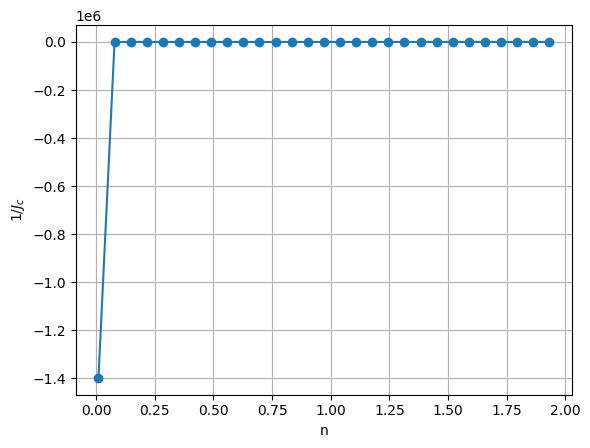

CPU times: user 5h 27min 26s, sys: 44.6 s, total: 5h 28min 11s
Wall time: 5h 29min 8s


In [3]:
%%time

plot_J_c_vs_n(
    n_values, p=0,
    max_k=2000,
    tol=1e-6,
    J_low=-3.0, J_high=-1e-10
)